In [7]:
!pip install -r requirements.txt
!pip install pygad

ERROR: Could not find a version that satisfies the requirement opencv_contrib_python_headless==4.5.2.54 (from versions: 3.4.0.14, 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64)
ERROR: No matching distribution found for opencv_contrib_python_headless==4.5.2.54


In [8]:
from src.intelligent_placer_lib import load_objects, check_image
import cv2 as cv
import matplotlib.pyplot as plt


## Основная функция пакета

Фуyкция check_image имеет один обязательный параметр:
- "image: Исходное изображение с полигоном и предметами.

И ещё один необязательный парааметр:
- "path": если он указан, то в указанную директорию будет происходить логгирование эксперимента. 

В данном блокноте будут рассмотрены результаты множества проведённых запусков, однако для демонстрации жизнеспособности алгоритма сделаем запуск c логгированием

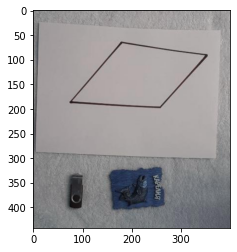

In [83]:
objects_path = "data/objects/"
dataset_path = "data/dataset\\"
test_image_path = f"{dataset_path}10_y_2.jpg"
test_image = cv.imread(test_image_path)
plt.imshow(test_image)

Запустим алгоритм

C:\Users\Egor_Marin\PycharmProjects\intelligent_placer\src\intelligent_placer_lib\detector.py:15: FutureWarning: `selem` is a deprecated argument name for `binary_closing`. It will be removed in version 1.0. Please use `footprint` instead.
  canny_image = binary_closing(canny(image, sigma=s), selem=np.ones((14, 14)))


data/dataset\10_y_2.jpg
UPDATED MIN 499950.0=>356250.0
UPDATED MIN 356250.0=>188547.0
UPDATED MIN 188547.0=>151200.0
|_________________________________________________ 2.5% GA is running...UPDATED MIN 151200.0=>99735.0
UPDATED MIN 99735.0=>99600.0
UPDATED MIN 99600.0=>93846.0
||________________________________________________ 5.0% GA is running...UPDATED MIN 93846.0=>92637.0
UPDATED MIN 92637.0=>90768.0
UPDATED MIN 90768.0=>13242.0
UPDATED MIN 13242.0=>9909.0
||||||____________________________________________ 12.5% GA is running...UPDATED MIN 9909.0=>4578.0
||||||||||________________________________________ 20.0% GA is running...UPDATED MIN 4578.0=>3750.0
|||||||||||||||___________________________________ 30.0% GA is running...UPDATED MIN 3750.0=>3714.0
UPDATED MIN 3714.0=>3300.0
||||||||||||||||__________________________________ 32.5% GA is running...UPDATED MIN 3300.0=>2208.0
||||||||||||||||||________________________________ 35.0% GA is running...UPDATED MIN 2208.0=>1995.0
|||||||||

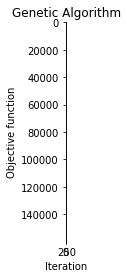

res: True


In [84]:
from src.intelligent_placer_lib.intelligent_placer import check_image
example_report = "output/reports/example/"
res = check_image(test_image_path, example_report)
print(f"res: {res}")

На тестовом запуске видна первая возможность для улучшения алгоритма: преждевременная остановка при достижении определенного уровня значений целевой функции.
Библиотека, используемая для оптимизации с помощью метода генетического алгоритма не даёт возможность преждевременной остановки

На данный момент я вижу два возможный решения:
- Использовать библиотеку с улучшенной инфраструктурой, например pygad
- Использовать механизм исключений и самостоятельно прерывать вычисления (решит проблему, но так делать нельзя)

# Описание работы алгоритма

## Целевая функция
Рассмотрим устройство целевой функции, используемой для оптимизации на примерах, посчитаных заранее

Для этого загрузим распознанные маски объектов и полигона для одного из изображений

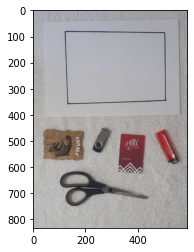

In [95]:
import os
import glob
from imageio import imread

dataset_path = "data/dataset/"
reports_path = "output/reports/" + "6_y_5/"
mask_path = reports_path + 'detection/'
image_path = dataset_path + "6_y_5.jpg"

image = imread(image_path)
plt.imshow(image)

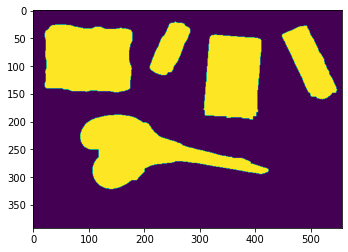

In [86]:
from src.intelligent_placer_lib.detector import get_masks
polygon, masks = get_masks(image)
# Маски объектов

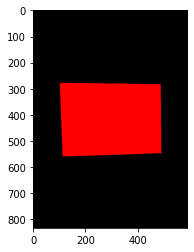

In [87]:
# Маска полигона
plt.imshow(polygon)

Рассмотрим поведение функции потерь на нескольких примерах расположения предметов относительно многоугольника

Loss correct inside: 0.0


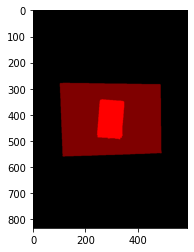

In [88]:
from src.intelligent_placer_lib.utils import transformed_sum
from src.intelligent_placer_lib.loss_functions import get_loss_func

obj = masks[1]
transforms = [0, 0, 0]*2
summ = transformed_sum(polygon, [obj], transforms)
normalized = cv.normalize(summ, None, 0, 255, cv.NORM_MINMAX).astype(int)
plt.imshow(normalized)
# создадим функцию потерь
loss = get_loss_func(polygon, [obj], callbacks=[])

print(f"Loss correct inside: {loss(transforms)}")

Функция принимает нулевое значение, т.к. объект уложен корректно 

Рассмотрим некорректную укладку с двумя объектами

Loss inside intersection: 57474.0


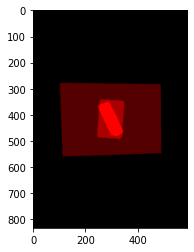

In [89]:
from src.intelligent_placer_lib.utils import transformed_sum
from src.intelligent_placer_lib.loss_functions import get_loss_func

objs = masks[1:3]
transforms = [0, 0, 0] * len(objs)
summ = transformed_sum(polygon, objs, transforms)
normalized = cv.normalize(summ, None, 0, 255, cv.NORM_MINMAX).astype(int)
plt.imshow(normalized)
# создадим функцию потерь
loss = get_loss_func(polygon, objs, callbacks=[])

print(f"Loss inside intersection: {loss(transforms)}")

Получаем крупный штраф за полное пересечение предметов

Теперь рассмотрим случай без пересечения, но с выходом за границу многоугольника

Loss outside: 975450.0


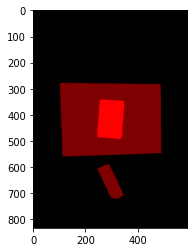

In [90]:
objs = masks[1:3]
transforms = [0, 0, 0, 30, 0, 0]
summ = transformed_sum(polygon, objs, transforms)
normalized = cv.normalize(summ, None, 0, 255, cv.NORM_MINMAX).astype(int)
plt.imshow(normalized)
# создадим функцию потерь
loss = get_loss_func(polygon, objs, callbacks=[])

print(f"Loss outside: {loss(transforms)}")

Получаем огромный штраф за выход предмета из многоугольника. Выход предметов за многоугольник штрафуется сильнее, чем их пересечение внутри многоугольника

Это демонстрирует основной принцип работы оптимизационного аглоритма: **сначала загнать все предметы внутрь многоугольника а затем попытаться расположить их внутри**

# Метрики и результаты

Помимо ответа на вопрос "Можно ли расположить предметы внутри многоугольника?" алгоритм сохраняет некоторые результаты

Рассмотри отчёт, сохраняемый алгоритмом для каждого эксперимента с логгированием

Для начала рассмотрим сам отчёт

In [93]:
import json
with open(reports_path + '/report.json') as f:
    report = json.load(f)
report

{'objects': {'computed': 5, 'real': '5'},
 'answer': {'computed': 'y', 'real': 'y'},
 'metrics': {'loss': 2697.0}}

*'computed'* - результат алгоритма  
*'real'* - реальное значение

**'objects'** - содержит информацию о количестве распознанных объектов

**'answer'** - ответ на поставленный вопрос. ВАЖНО: для положительного ответа не необходимо полное отсутствие пересечений внутри многоугольника (loss != 0). Из-за дискретизации шага точная укладка может быть слегка искажена, поэтому используется эмпирически подобранная эвристика, зависящая от числа распознанных объектов: ans = loss < 1200*len(objects)

**'metrics'** - содержит значения метрик (на данном этапе всего одна метрика)

Далее рассмотрим укладки, которые предлагал алгоритм. Они хранятся в директории loss и создаются по следующему принципу:  
Каждый раз, когда loss функция обновляет минимальное значение, создаётся новый снимок с соответствующей укладкой


Loaded 37 images


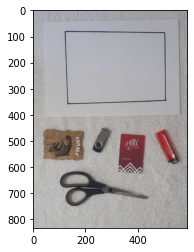

In [109]:
im_names = sorted([img for img in glob.glob(os.path.join(reports_path + 'loss/', r"*.png"))], key = lambda x: int((x.split('.')[-2].split('\\')[-1])))
images = [imread(img) for img in im_names]
print(f"Loaded {len(images)} images")
plt.imshow(imread(image_path))

# Рассмотрим входное изображение 

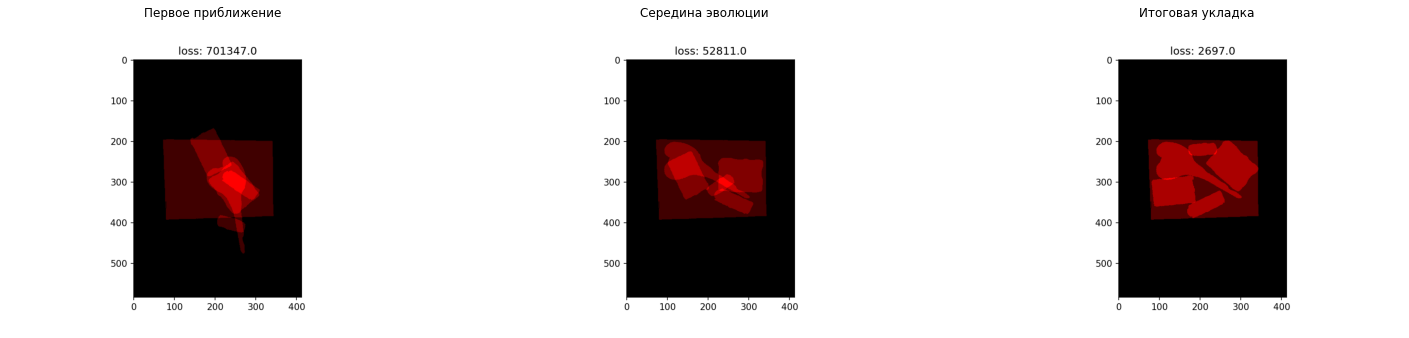

In [114]:
fig, ax = plt.subplots(1, 3, figsize=(25, 50))

ax[0].imshow(images[0])
ax[0].set_title('Первое приближение')
ax[0].set_axis_off()

ax[1].imshow(images[len(images)//2])
ax[1].set_title('Середина эволюции')
ax[1].set_axis_off()

ax[2].imshow(images[-1])
ax[2].set_title('Итоговая укладка')
ax[2].set_axis_off()

Видно, что объекты развернулись относительно исходного положения на снимке. Возможность вращать предметы является важнейшим преимуществом данного алгоритма укладки

Кроме того, важна гибкость определения функции потерь, которую можно подстраивать под определенные задачи. Например, можно допустить выход части объектов за границу многоугольника или ввести штраф за близость объектов для максимизации зазоров между ними

Рассмотрим пример укладки для тестового запуска из верхних ячеек ноутбука

Loaded 20 images


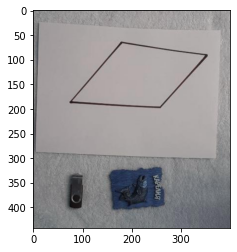

In [116]:
im_names = sorted([img for img in glob.glob(os.path.join(example_report + '10_y_2/loss/', r"*.png"))], key = lambda x: int((x.split('.')[-2].split('\\')[-1])))
images = [imread(img) for img in im_names]
print(f"Loaded {len(images)} images")
plt.imshow(test_image)

# Рассмотрим входное изображение 

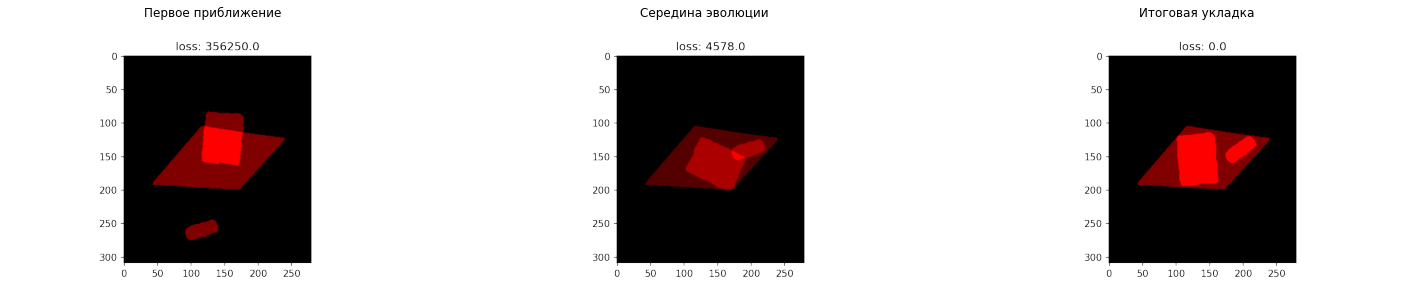

In [120]:
fig, ax = plt.subplots(1, 3, figsize=(25, 50))

ax[0].imshow(images[0])
ax[0].set_title('Первое приближение')
ax[0].set_axis_off()

ax[1].imshow(images[len(images)//2])
ax[1].set_title('Середина эволюции')
ax[1].set_axis_off()

ax[2].imshow(images[-1])
ax[2].set_title('Итоговая укладка')
ax[2].set_axis_off()

## Результаты для датасета

In [129]:
import json

reports = []
for report_dir in glob.glob(os.path.join("output/reports/", r"*")):
    exp_name = report_dir.split('\\')[-1]
    if exp_name == "example": # DUPLICATED CASE
        continue
    with open(report_dir + '/report.json') as f:
        report = json.load(f)
        report['name'] = exp_name 
        reports.append(report)
print(f"Loaded {len(reports)} reports")

Loaded 14 reports


Вычислим процент верных предсказаний

In [130]:
good_predictions = list(filter(lambda x: x['answer']['computed'] == x['answer']['real'], reports))
print(f"Good predictions: {round(len(good_predictions)/len(reports) * 100, 2)}%")

Good predictions: 85.71%


Посмотрим на плохие предсказания

In [131]:
bad_predictions = list(filter(lambda x: x['answer']['computed'] != x['answer']['real'], reports))
for report in bad_predictions:
    print(report['name'])

14_y_2
1_y_3


{'loss': 14220.0}


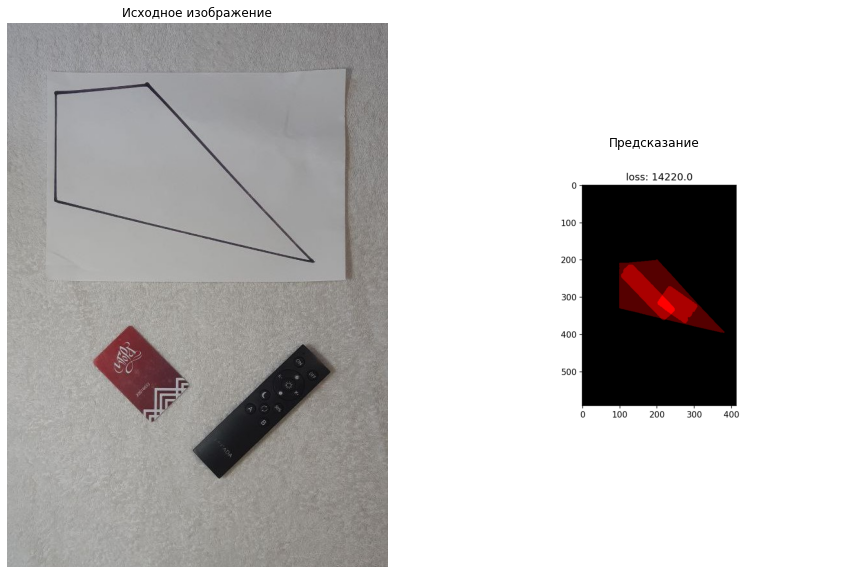

In [137]:
im_names = sorted([img for img in glob.glob(os.path.join(f"output/reports/{bad_predictions[0]['name']}/loss/", r"*.png"))], key = lambda x: int((x.split('.')[-2].split('\\')[-1])))
images = [imread(img) for img in im_names]


fig, ax = plt.subplots(1, 2, figsize=(15, 25))

ax[0].imshow(imread(dataset_path+bad_predictions[0]['name'] + '.jpg'))
ax[0].set_title('Исходное изображение')
ax[0].set_axis_off()

ax[1].imshow(images[-1])
ax[1].set_title('Предсказание')
ax[1].set_axis_off()

print(bad_predictions[0]['metrics'])

В данном случае укладка возможна, если вульт положить в сужение многоугольника. Однако, судя по всему, популяция выродилась в локальном минимуме при неправильной укладке. Возможно, ситуацию могло исправить уменьшение доли родителей в последующих поколениях или увеличение размера популяции

В любом случае, данный случай типичен и показывает важнейшую проблему данного алгоритма: сложность вычислений. Функция потерь трудновычислима, поэтому генетический алгоритм не может обработать большие популяции за вменяемое время и может происходить вырождение

Потенциальные выходы: кеширование значений функции потерь / упрощение функции потерь / сжатие изображения / подбор границ поиска в зависимости от размера полигона / другие эвристики

{'loss': 6975.0}


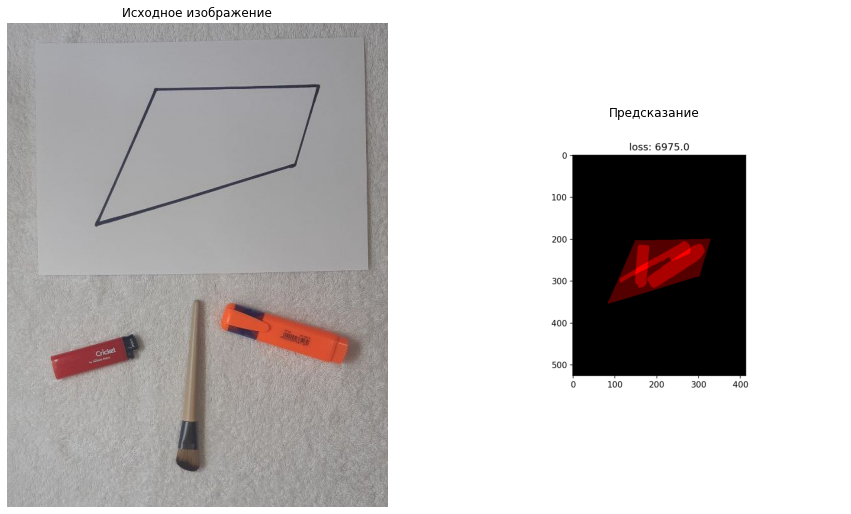

In [140]:
im_names = sorted([img for img in glob.glob(os.path.join(f"output/reports/{bad_predictions[1]['name']}/loss/", r"*.png"))], key = lambda x: int((x.split('.')[-2].split('\\')[-1])))
images = [imread(img) for img in im_names]


fig, ax = plt.subplots(1, 2, figsize=(15, 25))

ax[0].imshow(imread(dataset_path+bad_predictions[1]['name'] + '.jpg'))
ax[0].set_title('Исходное изображение')
ax[0].set_axis_off()

ax[1].imshow(images[-1])
ax[1].set_title('Предсказание')
ax[1].set_axis_off()

print(bad_predictions[1]['metrics'])

На втором примере другой фейл: Некорректное распознавание кисточки из-за тени

Оно помешало расположитьпредметы корректным образом

Потенциальное решение: существенаня предобработка изображения перед распознаванием